# Credit Fraud Detector

## Our Goals:
- 적은 데이터를 가지고 적은 분포 이해하기
- Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm)
- "Fraud" 및 "Non-Fraud" 트랜잭션의 50/50 하위 데이터 프레임 비율 생성
- 사용할 classifier를 결정하고 정확도가 더 높은 classifier 결정하기
- Neural Network를 생성하고 정확성을 best classifier과 비교
- 불균형 데이터셋으로 인한 일반적인 실수 이해


<h2> Outline: </h2>
I. <b>Understanding our data</b><br>
a) [Gather Sense of our data](#gather)<br><br>

II. <b>Preprocessing</b><br>
a) [Scaling and Distributing](#distributing)<br>
b) [Splitting the Data](#splitting)<br><br>

III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>
b) [Anomaly Detection](#anomaly)<br>
c) [Dimensionality Reduction and Clustering (t-SNE)](#clustering)<br>
d) [Classifiers](#classifiers)<br>
e) [A Deeper Look into Logistic Regression](#logistic)<br>
f) [Oversampling with SMOTE](#smote)<br><br>

IV. <b>Testing </b><br>
a) [Testing with Logistic Regression](#testing_logistic)<br>
b) [Neural Networks Testing (Undersampling vs Oversampling)](#neural_networks)


## Correcting Previous Mistakes from Imbalanced Datasets:
- 오버샘플링되거나 언더샘플링된 데이터셋에서 테스트하지 않기
- 교차 검증을 구현하려면 이전이 아니라 교차 검증 중에 train data를 오버샘플링하거나 언더샘플링해야 함
- 부정확한 데이터셋이 있는 메트릭으로 정확도 점수를 사용하지 않기, 대신 f1 점수, 정밀도/호출 점수 또는 혼돈 매트릭스를 사용


## References:
- Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron
- https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a>by Coding-Maniac
- https://www.kaggle.com/lane203j/auprc-5-fold-c-v-and-resampling-methods auprc, 5-fold c-v, and resampling methods
by Jeremy Lane (Kaggle Notebook)


## Gather Sense of Our Data:

### Summary:
- transaction amount (거래금액)이 비교적 적음. 모든 mount의 펴균은 대략 USD 88이다
- NULL값 없음
- transaction은 Non-Fraud=99.83% Fraud=0.71%

### Feature Technicalities: 
- PCA Transformation: 데이터에서 모든 feature는 PCA를 거쳤다 (time과 amount 제외)
- Scaling: PCA Transformation을 구현하려면 그 전에 scaling을 해야한다. (이 경우 모든 V feature가 scale되었거나 최소한 데이터 세트를 개발한 사용자가 scale했다고 가정한다.)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time


# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
# Good No Null Values!
df.isnull().sum().max()

0

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


- No Fraud가 거의 99%로 데이터셋이 굉장히 불균형하다는 것을 알 수 있다. 해당 데이터를 예측 모델 및 분석의 기반으로 사용하면 많은 오류가 발생할 수 있다. 특히 대부분의 거래가 No Fraud라고 추정하면 알고리즘이 overfitting이 될 수 있다.

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

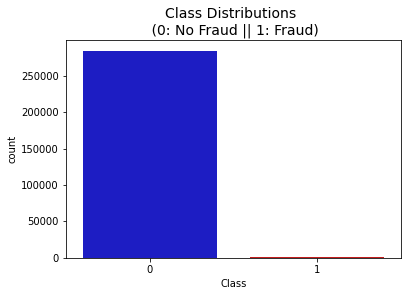

In [12]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

- **Distribution**: 분포를 보면 이러한 특징이 얼마나 왜곡되어 있는지 알 수 있으며, 다른 특징에 대한 추가 분포도 볼 수 있다. 향후 분포 왜곡을 줄이는 데 도움이 되는 기술 나옴

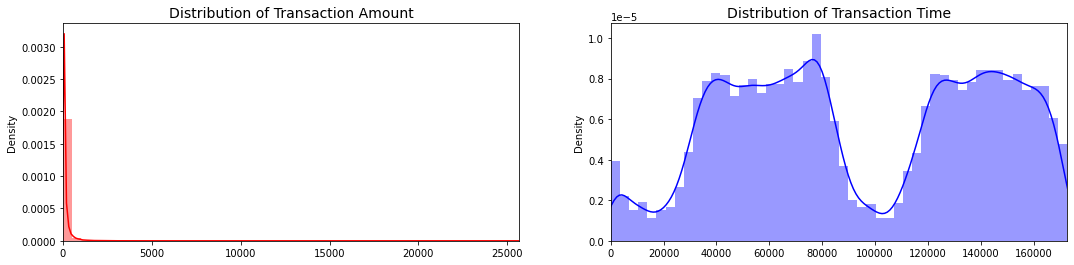

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

## Scaling and Distributing
<a id="distributing"></a>
- 먼저 time과 amount로 구성된 열 scale하기 (다른 열과 동등하게 scale 해야함)
- 또한 동일한 양의 fraud 및 non-fraud를 포함하려면 데이터 프레임의 하위 샘플을 생성하여 알고리즘이 부정 행위 여부를 판단하는 패턴을 보다 잘 이해할 수 있도록 해야 한다.

### What is a sub-Sample?
- subsample은 fraud 및 non-fraud transaction 비율이 50/50인 데이터 프레임
- 즉, subsample의 fraud 및 non-fraud transaction의 양이 동일하다

### Why do we create a sub-Sample?
- 원본 데이터 프레임의 균형이 크게 맞지 않는 것을 확인했음 (fraud와 non-fraud 비율 확인)
- 원본 데이터 프레임을 사용하면 다음과 같은 문제가 발생함

#### Overfitting
우리의 classification은 대부분의 경우 fraud가 없다고 가정하자. 우리의 목적은 fraud가 발생했을 때 이게 확실히 fraud라고 예측하는 것이다.
#### Wrong Correlations
V feature가 무엇을 의미하는지는 모르지만, 각 feature가 결과에 어떤 영향을 미치는지(fraud 또는 non-fraud) 클래스 및 feature 간의 실제 상관 관계를 확인할 수 없는 불균형 데이터 프레임을 사용하면 유용하다


### Summary
- scaled된 amount와 scaled된 time은 scaled values이 있는 열이다
- dataset에 492건의 fraud가 있으므로 496건의 non-fraud를 랜덤으로 받아 새로운 sub dataframe 생성 가능
- 492건의 fraud, non-fraud를 합쳐서 새로운 sub-sample을 만든다

In [14]:
# Amount, Time scaling 하기 (나머지는 이미 PCA를 통해서 차원축소된 상태)
# RobustScaler는 outlier의 영향을 최소화 한다
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [15]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the Data (Original DataFrame)
<a id="splitting"></a>
- random UnderSampling을 진행하기 전에 원래 데이터 프레임을 분리해야 한다
- why? 테스트 목적으로 random UnderSampling 또는 OverSampling을 사용할 때 데이터를 분할하지만, 우리는 우리의 model을 이러한 기법을 통한 testing set이 아니라 original testing set에서 테스트하길 원한다
- 목표: UnderSample 및 OverSample이었던 dataframe에 model을 fit하고 원래 test set에서 test하기

In [22]:
len(X), len(original_Xtrain), len(original_Xtest)

(284807, 227846, 56961)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print()

print('Label Distributions:')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]

Label Distributions:
[0.99827076 0.00172924]
[0.99827952 0.00172048]


## Random Under-Sampling
- Random Under Sampling은 데이터를 제거해서 보다 균형 잡힌 dataset을 확보함으로써 model이 overfitting되는 것을 막는다

#### Steps
- 첫 번째로 해야 할 일은 클래스가 얼마나 불균형한지를 결정하기 (클래스 열의 "value_counts()"를 사용하여 각 레이블의 양을 결정)
- fraud transcation(fraud = "1")의 수를 파악하면 fraud transcation과 동일한 양으로 non-fraud transcation을 처리해야 한다 (50/50 비율을 원하는 경우). 이는 fraud 492건 및 non-fraud 492건에 해당된다.
- 이 기법을 구현한 후에는 클래스에 대한 50/50 비율의 dataframe sub-sample이 제공된다. 그다음 모델이 일정한 정확도를 유지할 수 있는지 확인하기 위해 데이터를 셔플링한다

#### Note
- Random Under-Sampling의 주요 문제는 정보 손실이 크기 때문에 분류 모델이 원하는 만큼 정확하게 수행되지 않을 위험이 있다는 것
- 284,315건의 non-fraud에서 492건만 사용하기 때문

In [32]:
df = df.sample(frac=1)   # data shuffling

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

print(new_df.shape)
new_df.head()

(984, 31)


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
183778,-0.225669,0.484674,-1.755505,2.316372,-2.068939,-0.221682,-0.252247,-0.856375,-0.396423,1.596773,...,-0.454492,0.085911,-0.294997,0.107778,0.625612,0.011733,-0.452293,-0.602286,-0.139245,0
16863,9.905121,-0.663189,-2.787248,-0.071340,-1.505288,3.361777,-3.357422,0.565835,0.303653,0.966914,...,1.607397,0.882940,-0.246202,1.752227,0.219925,0.156282,-0.265894,0.220694,0.256077,1
187301,0.391253,0.502602,1.979108,-0.444306,-1.296628,0.151284,-0.071027,-0.540209,-0.030167,-0.129399,...,-0.171977,-0.168228,-0.406089,0.197037,0.567531,-0.065044,-0.114013,-0.043978,-0.044901,0
167184,1.172221,0.397561,-5.961457,5.313382,-6.674320,6.028975,-1.387560,0.670638,-4.128987,-4.765894,...,-1.116581,5.556642,-1.501808,1.355172,0.141093,0.077913,0.473988,0.287129,1.468653,1
142405,-0.135401,0.000023,-4.868108,1.264420,-5.167885,3.193648,-3.045621,-2.096166,-6.445610,2.422536,...,0.667310,1.269205,0.057657,0.629307,-0.168432,0.443744,0.276539,1.441274,-0.127944,1


##  Equally Distributing and Correlating: 
<a id="correlating"></a>
dataframe의 균형을 조정했으므로 그 다음 분석 및 전처리 하기

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


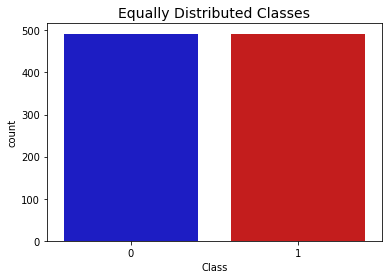

In [33]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Correlation Matrices
- 특정 거래가 사기인지 여부에 큰 명향을 미치는 feature을 correlatoin matrices를 통해 알아보기
- fraud transcation과 관련해 양 또는 음의 상관관계까 높은 feature을 확인하려면 올바른 dataframe 사용해야한다


### Summary and Explanation
- Negative Correlations: V17, V14, V12, V10은 음의 상관관계이다. 해당 값들은 낮을수록 최종 결과는 fraud transaction일 가능성 커짐
- Positive Correlations: V2, V4, V11, V19는 양의 상관관계이다. 해당 값들은 높을수록 최종 결과는 fraud transaction일 가능성 커짐
- BoxPlots: box plots를 통해 이러한 fraud 및 non-fraud transaction의 분포를 더 잘 이해할 수 있다

#### Note
- correlatoin matrices에서 subsample을 사용하지 않으면 class 간의 높은 불균형에 의해 영향을 받게 된다.
- 이 문제는 원래 dataframe의 높은 클래스 불균형으로 인해 발생한다.

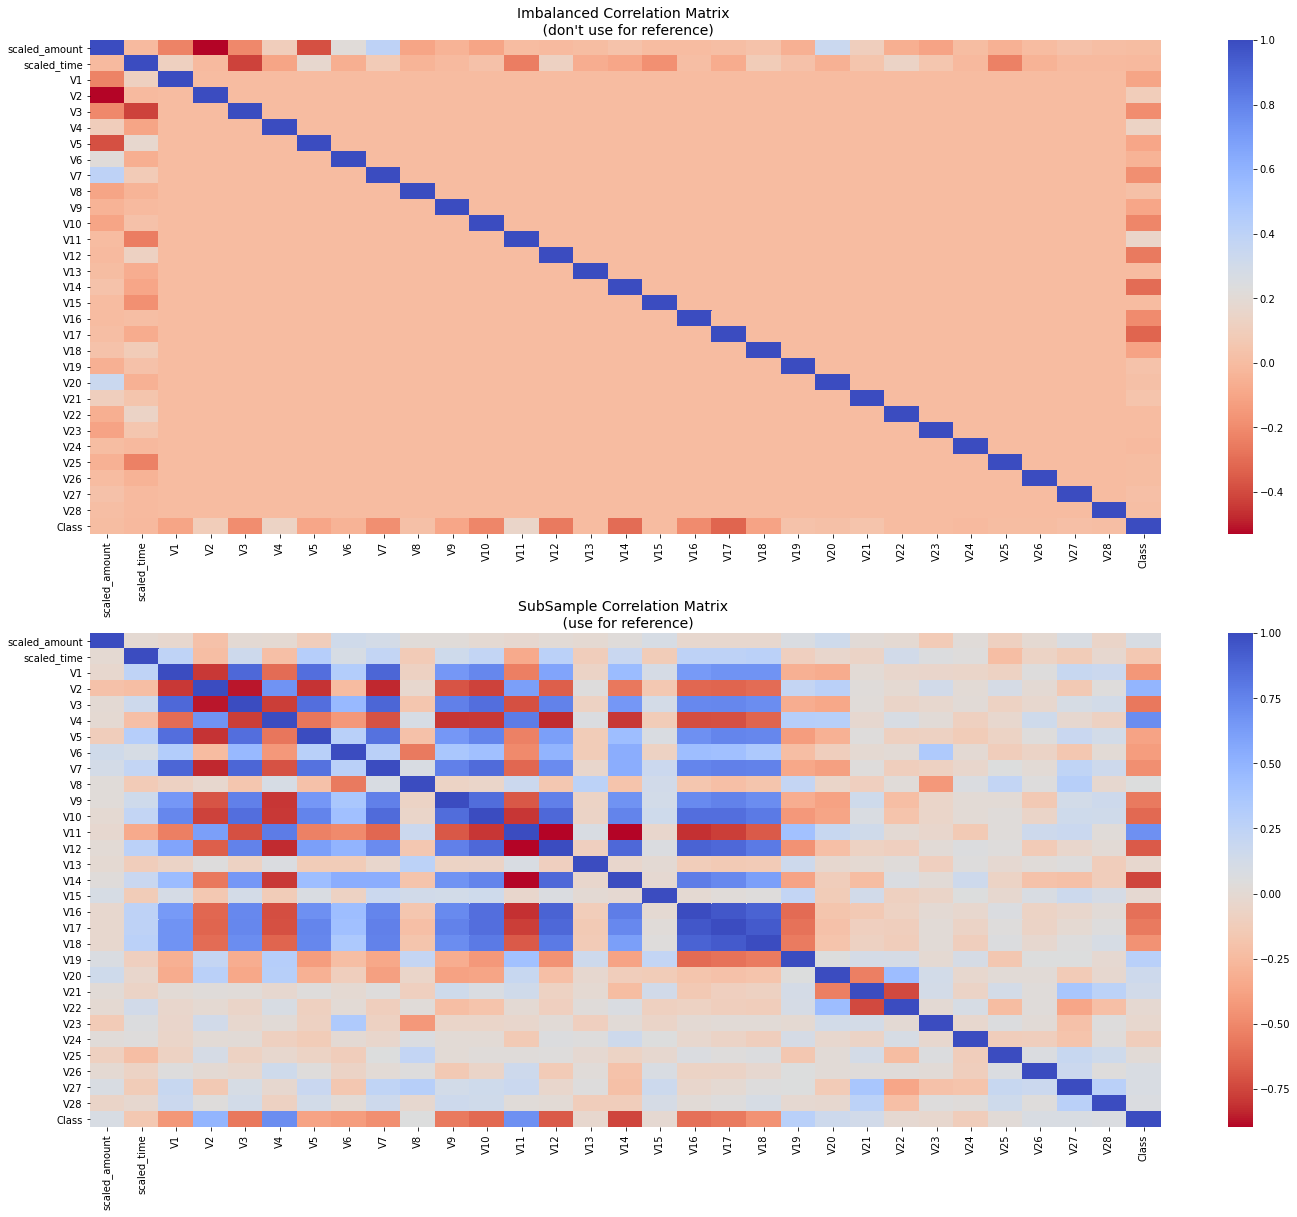

In [34]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

plt.show()

### negative correlation with our class (낮을수록 fraud)
- SubSampling Correlation Matrix에서의 빨간 부분

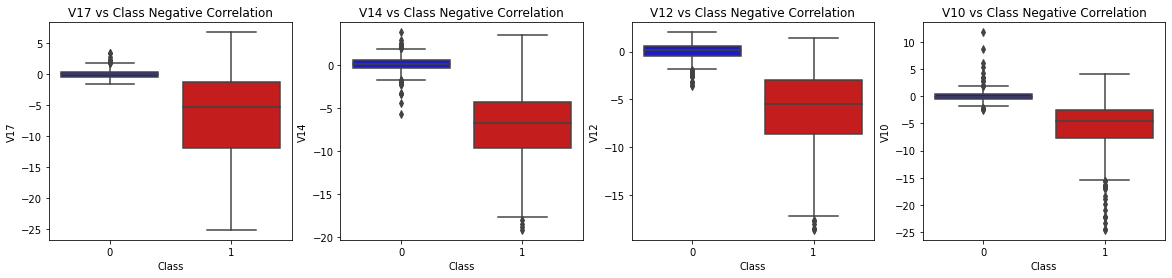

In [35]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

### positive correlation with our class (높을수록 fraud)
- Subsampling correlation Matrix에서의 파란 부분

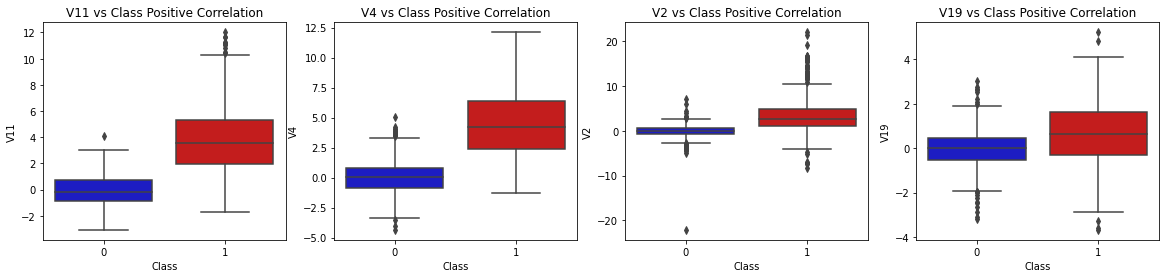

In [36]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Anomaly Detection
<a id="anomaly"></a>
목표: class와 높은 상관관계를 갖는 feature에서 "extreme outliers"을 제거하는 것 (모델의 정확성에 기여)

### Interquartile Range Method
- Interquartile Range (IQR): 75th 백분위 - 25th 백분위, 목표는 75th 및 25th 백분위수를 초과하는 threshold을 생성하여 일부 instance가 이 threshold을 초과할 경우 instance를 삭제하는 것
- Boxplots: 25th 및 75th 백분위수와 outlier도 쉽게 볼 수 있다 (outlier: 양끝 선 너머의 점들)

### Outlier Removal Tradeoff
- outlier를 제거하기 위한 threshold 정하기가 중요
- threshold는 interquartile range를 곱해서 결정
- threshold가 높을수록 탐지하는 outlier가 적어짐, threshold이 낮을수록 탐지하는 outlier가 많아짐

#### The Tradeoff
- threshold가 낮을수록 더 많은 outlier를 제거할 수 있지만, outlier보다는 "extreme outliers"에 더 초점을 맞춘다
- 그 이유는 정보 손실의 위험이 있기 때문에 모델의 정확도가 낮아질 수 있기 때문이다
- threshold를 사용하여 분류 모델의 정확도에 어떤 영향을 미치는지 확인할 수 있다

### Summary
-  Visualize Distributions: 먼저 outlier를 제거하기 위해 사용할 feature의 distribution을 시각화한다. V14는 V12와 V10과 비교해서 Gaussian distribution을 갖는 유일한 feature이다
- Determining the threshold: iqr에 곱하기 위해 사용할 숫자를 결정한 후, 하한 threshold=(Q25 - 하위극한 threshold), 상한 threshold=(Q75 + 상위극한 threshold)
- Conditional Dropping: 양쪽 극단에서 threshold를 초과하면 인스턴스가 제거된다는 conditional dropping 생성
- Boxplot Representation: 상자 그림을 통해 "extreme outlier"의 수가 상당한 양으로 감소했음을 시각화

#### Note
- implementing outlier을 구현한 후 정확도가 3% 이상 향상됨
- 일부 outlier는 모델의 정확도를 왜곡할 수 있지만, 극심한 정보 손실을 피하지 않으면 모델이 부적합할 위험이 있다


#### Reference
https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

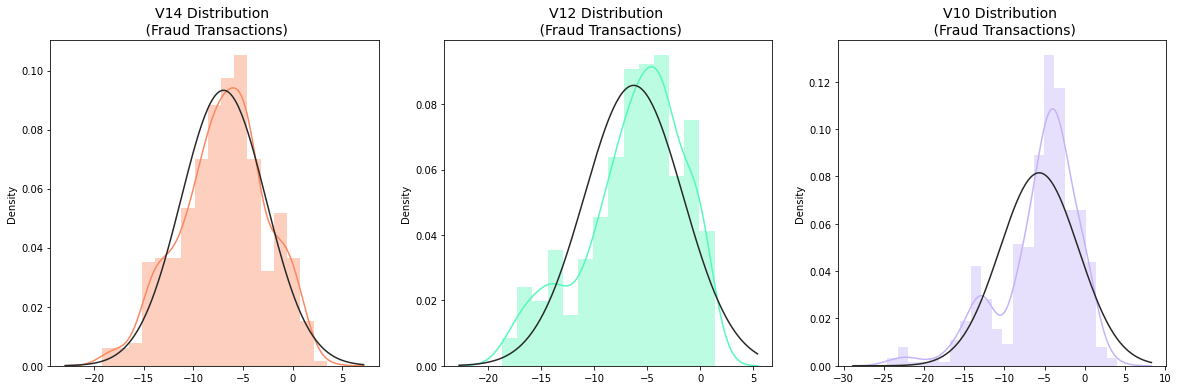

In [37]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [38]:
### V14 removing outliers
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print()


### V12 removing outliers
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print()


### V10 removing outliers
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -18.049997689859396, -19.2143254902614, -18.8220867423816]

V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.553697009645802, -18.047596570821604, -18.683714633344298, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976

V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-19.836148851696, -15.563791338730098, -15.1237521803455, -22.1870885620007, -22.1870885620007, -16.2556117491401, -15.563791338730098, -15.2399619587112, -20.949191554361104, -24.5882624372475, -23.2282548357516, -22.1870885620007, -14.9246547735487, -22.1870885620007, -16.6011969664137, -18.2711681738888, -17.141513641289198, -24.403184969972802, -16.3035376590131, -1

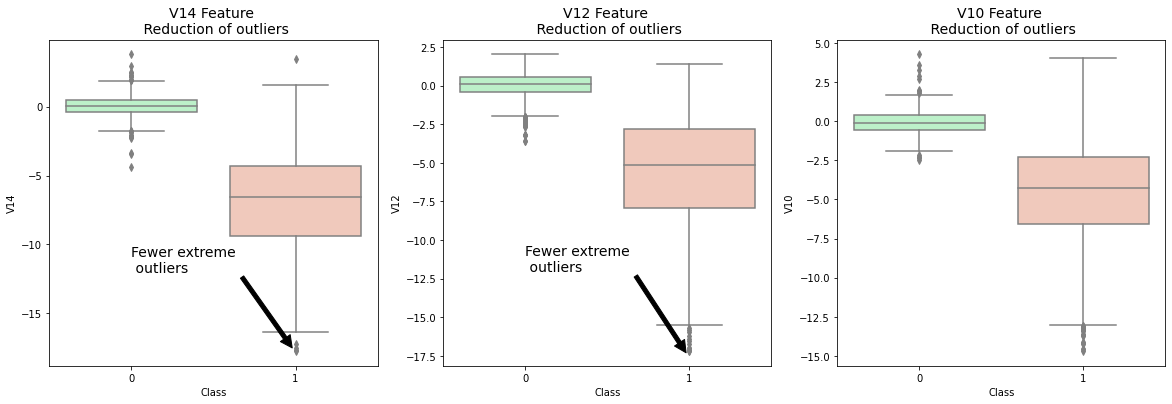

In [39]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

## Dimensionality Reduction and Clustering
<a id="clustering"></a>

### Understanding t-SNE
- Euclidean Distance
- Conditional Probability
- Normal and T-Distribution Plots

#### Note
https://www.youtube.com/watch?v=NEaUSP4YerM

### Summary
- t-SNE 알고리즘: 데이터셋에서 fraud 및 non-fraud를 정확하게 클러스터링할 수 있다
- sub-sample은 매우 작지만, t-SNE 알고리즘이 cluster를 매우 정확하게 감지할 수 있다 (t-SNE 실행하기 전 data shuffle)

In [40]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.0 s
PCA took 0.014 s
Truncated SVD took 0.0039 s


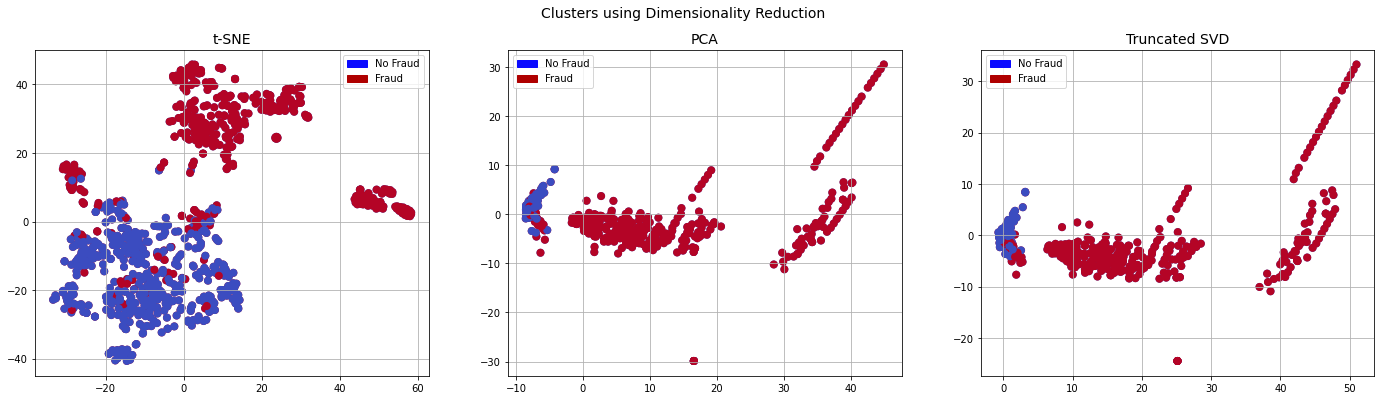

In [41]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch  = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud',    linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud',    linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])


# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud',    linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## Classifiers (UnderSampling)
<a id="classifiers"></a>
네 가지 classifier를 훈련하고 어떤 classifier가 fraud detection을 하는데 더 효과적일지 결정

## Summary
- Logistic Regression classifier: 다른 세 classifier보다 정확함
- GridSearchCV: classifier에 대해 best predictive score를 제공하는 파라미터 결정
- Logistic Regression: ROC 점수가 가장 높기 때문에 Logistic Regression는 fraud와 non-fraud transaction을 정확하게 구분

## Learning Curve
- training score와 validation score의 차이가 클수록 모형이 overfitting(high variance)될 가능성이 높다
- train 및 val set에서 점수가 낮은 경우 이는 모델이 적합하지 않음을 나타낸다 (high variance)
- Logistic Regression Classifier는 train 및 val set 모두에서 최상의 score 보임

In [46]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [49]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [50]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "training score:", round(training_score.mean(), 2) * 100, "% accuracy score")

LogisticRegression training score: 94.0 % accuracy score
KNeighborsClassifier training score: 93.0 % accuracy score
SVC training score: 94.0 % accuracy score
DecisionTreeClassifier training score: 89.0 % accuracy score


In [51]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression GridSearch
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_


# KNeighbors Classifier GridSearch
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_


# Support Vector Classifier GridSearch
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_


# DecisionTree Classifier GridSearch
tree_params = {"criterion": ["gini", "entropy"],
               "max_depth": list(range(2,4,1)), 
               "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [52]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score:', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score:', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score:', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score:', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score: 94.31%
Knears Neighbors Cross Validation Score: 94.05%
Support Vector Classifier Cross Validation Score: 94.18%
DecisionTree Classifier Cross Validation Score: 92.46%


In [53]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
from imblearn.under_sampling import RandomUnderSampler  
X_nearmiss, y_nearmiss = RandomUnderSampler().fit_resample(undersample_X.values, undersample_y.values)
#X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)

print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))


for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56951  56952  56953 ... 284804 284805 284806] Test: [    0     1     2 ... 60771 61307 61722]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56951  56952  56953 ... 114489 115019 115041]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113920 113921 113922 ... 173859 173978 174411]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170877 170878 170879 ... 229063 229795 230699]
Train: [     0      1      2 ... 229063 229795 230699] Test: [227842 227843 227844 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [54]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
        
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

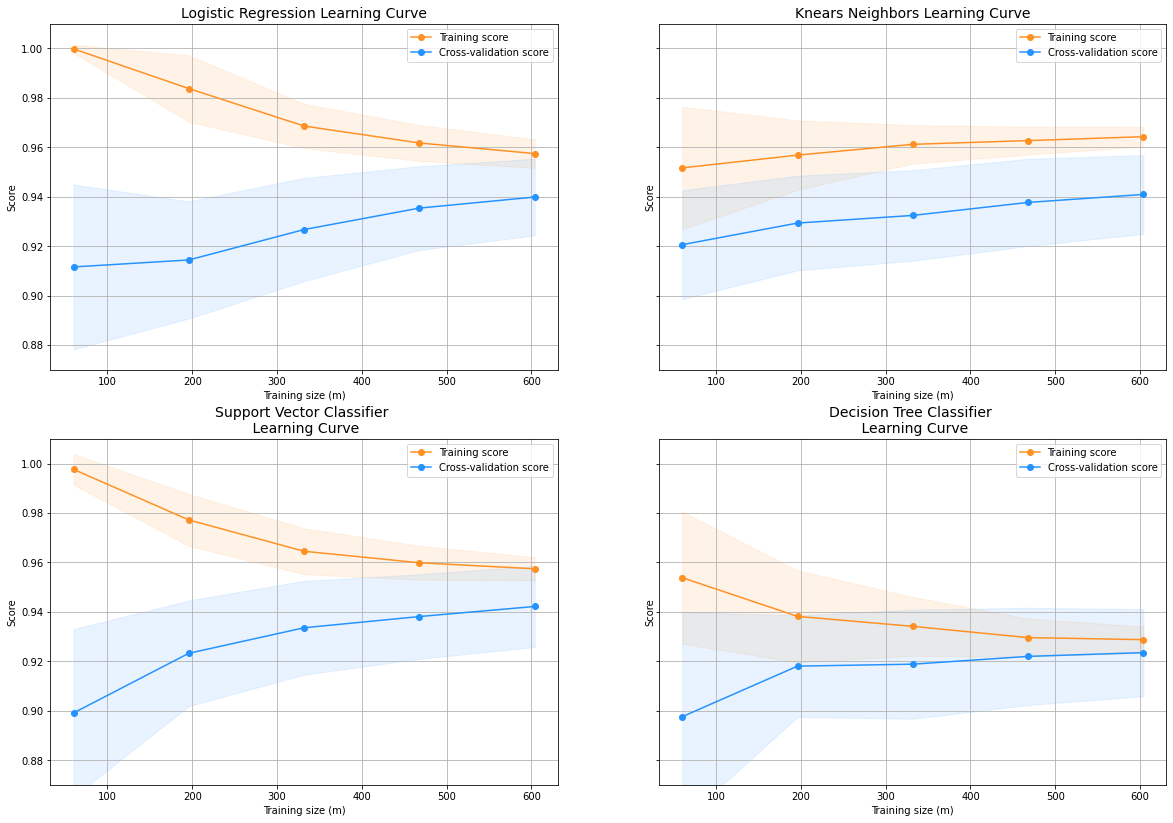

In [55]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [56]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [57]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression:', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors:', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier:', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier:', roc_auc_score(y_train, tree_pred))

Logistic Regression: 0.9724183877415055
KNears Neighbors: 0.9383884427925243
Support Vector Classifier: 0.9694098671061397
Decision Tree Classifier: 0.9216487254111295


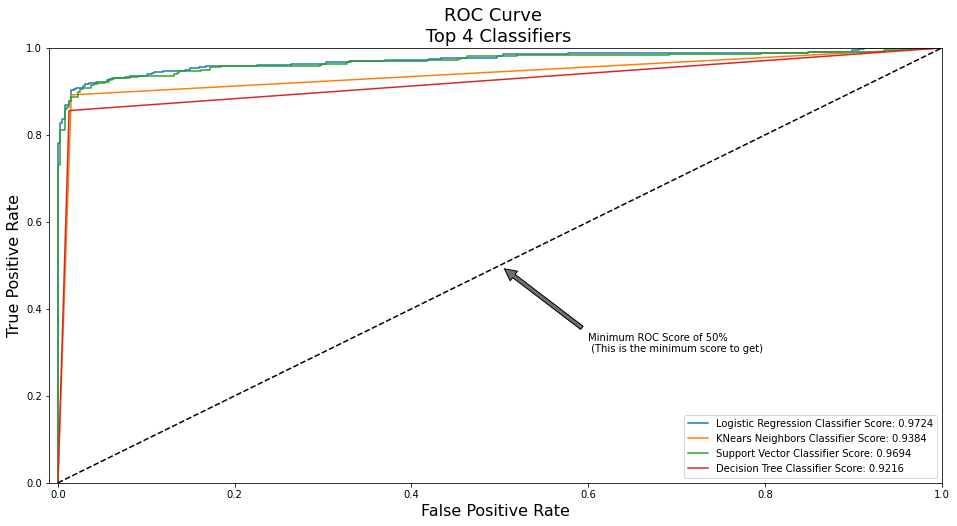

In [58]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)',
                 xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),)
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## A Deeper Look into LogisticRegression
<a id="logistic"></a>


### Terms
- True Positive: 실제 True인 정답을 True라고 예측 (정답)
- True Negative: 실제 False인 정답을 False라고 예측 (정답)
- False Negative: 실제 True인 정답을 False라고 예측 (오답)
- False Positive: 실제 False인 정답을 True라고 예측 (오답)
- Precision: TP / (TP + FP) Positive라고 예측한 것중 맞은거= 모델이 fraud transaction을 탐지하는 데 얼마나 정확한지(얼마나 확실한지)
- Recall: TP / (TP + FN) 실제 True인데 맞춘거= 모델이 탐지할 수 있는 fraud 양
- Precision/Recall Tradeoff: 모델이 더 정밀할수록 더 적은 사례를 탐지할 수 있다

### Summary
Precision이 0.90에서 0.92 사이로 떨어지기 시작하지만 precision score는 여전히 매우 높고 recall은 떨어진다

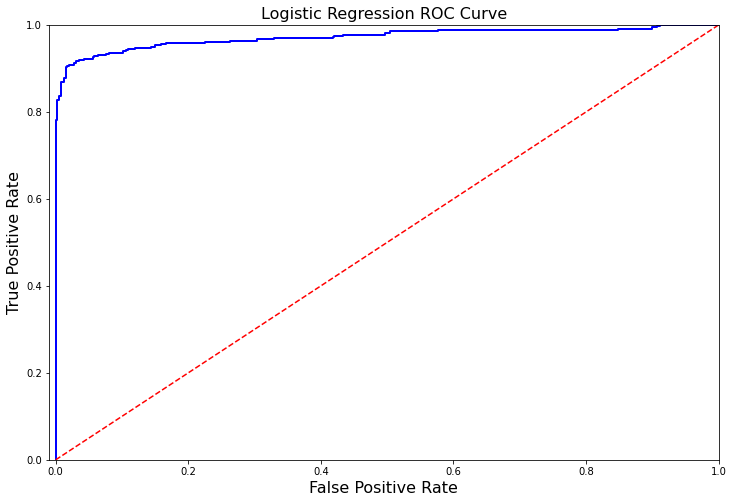

In [59]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [60]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [64]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('Overfitting >>')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print()

# How it should look like
print('How it should be >>')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))

Overfitting >>
Recall Score: 0.94
Precision Score: 0.70
F1 Score: 0.81
Accuracy Score: 0.78

How it should be >>
Accuracy Score: 0.52
Precision Score: 0.00
Recall Score: 0.49
F1 Score: 0.00


In [39]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [40]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(undersample_average_precision))

Average precision-recall score: 0.06


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.06')

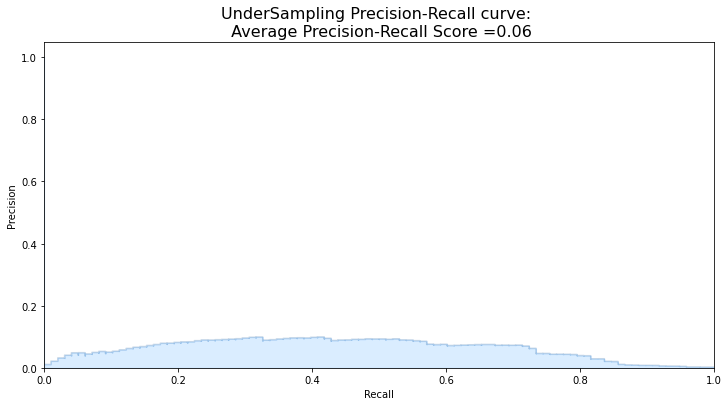

In [41]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

### SMOTE Technique (Over-Sampling)
<a id="smote"></a>
<img src="https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png"><br>
<b>SMOTE</b>(Synthetic Minority Over-Sampling Technology): random UnderSampling과 달리 SMOTE는 class의 균형을 동일하게 유지하기 위해 새로운 synthetic point를 생성한다. 이것은 class imbalance problem를 해결하기 위한 또 다른 대안이다 <br><br>


#### Understanding SMOTE
- Class Imbalance 해결: SMOTE는 소수계층과 다수계층 사이의 균등한 균형에 도달하기 위해 소수계층으로부터 synthetic point를 만들어낸다
- Location of the synthetic points: SMOTE는 소수 클래스의 가장 가까운 이웃 사이의 거리를 선택하고, 이러한 거리 사이의 거리를 합성 점을 생성합니다.
- 최종 효과: random Undersampling과 달리 행을 삭제할 필요가 없기 때문에 더 많은 정보 유지
- Accuracy | Time Tradeoff: SMOTE는 random Undersampling보다 더 정확할 가능성이 높지만, 행이 제거되지 않기 때문에 훈련하는 데 더 많은 시간이 걸릴 것이다

### Cross Validation Overfitting Mistake
## Overfitting during Cross Validation
- 데이터를 언더샘플링하거나 오버샘플링하는 경우 교차 검증하기 전에 먼저 언더샘플링을 수행하지 않는 것이 좋다
- 교차 검증을 구현하기 전에 implementing val set에 직접 영향을 미치므로 "data leakage" 문제가 발생한다

### The Wrong Way
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>
- 만약 소수계급을 얻고, 교차 검증하기 전에 합성점을 만든다면, 우리는 교차 검증 과정의 "검증 집합"에 특정한 영향을 끼친다
- 데이터를 5개의 배치로 나누고, 데이터 세트의 4/5가 train set이고, 1/5이 val set이다. 아래와 같이 "cross validation" 중에 합성 데이터 지점을 생성해야 한다.


### The Right Way
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
위에서 보다시피 SMOTE는 cross validation 전이 아닌 cross validation 중에 발생한다. val set에 영향을 주지 않고 train set에 대해서만 통합 데이터가 생성된다.


#### References
- https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
- http://rikunert.com/SMOTE_explained
- https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s

In [42]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))


accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print()
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9424179087827096
precision: 0.06204501025212626
recall: 0.9137293086660175
f1: 0.11429016633735078
---------------------------------------------------------------------------------------------------------------------------------------


In [43]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.85      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [44]:
y_score = best_est.decision_function(original_Xtest)

In [45]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.76


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.76')

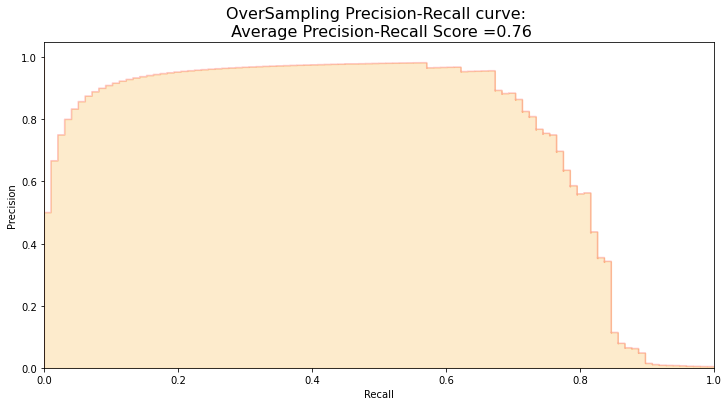

In [46]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [49]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [50]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took : {} sec".format(t1 - t0))

Fitting oversample data took :22.4336416721344 sec


# Test Data with Logistic Regression
<a id="testing_logistic"></a>
## Confusion Matrix
- Positive/Negative: Non-Fraud/Fraud
- True/False: 예측 맞음/틀림
- True Positive: 실제 True인 정답을 True라고 예측 (정답) $\rightarrow$ 오른쪽아래
- True Negative: 실제 False인 정답을 False라고 예측 (정답) $\rightarrow$ 왼쪽위
- False Negative: 실제 True인 정답을 False라고 예측 (오답) $\rightarrow$ 오른쪽위
- False Positive: 실제 False인 정답을 True라고 예측 (오답) $\rightarrow$ 왼쪽아래

### Summary
- Random UnderSampling: subset에서 분류 모델의 최종 성능을 평가 (original dataframe 아님)
- Classification Model: 최상의 성능을 발휘한 모델은 Logistic Regression 및 SVM

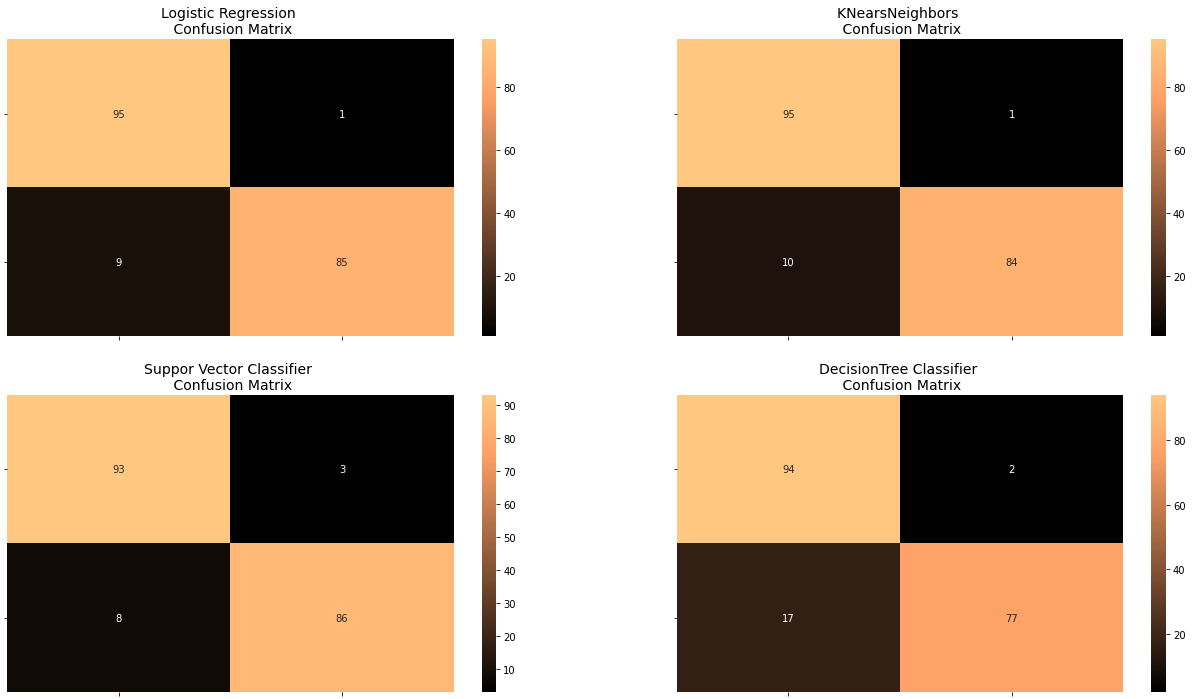

In [51]:
from sklearn.metrics import confusion_matrix

y_pred_log_reg = log_reg_sm.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [52]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        96
           1       0.99      0.90      0.94        94

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95        96
           1       0.99      0.89      0.94        94

    accuracy                           0.94       190
   macro avg       0.95      0.94      0.94       190
weighted avg       0.95      0.94      0.94       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        96
           1       0.97      0.91      0.94        94

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted

In [53]:
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Technique,Score
0,Random UnderSampling,0.947368
1,Oversampling (SMOTE),0.988483


## Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE)
<a id="neural_networks"></a>
이 섹션에서는 (샘플 부족 또는 오버샘플(SMOTE)에서 구현한 두 로지스틱 회귀 모델 중 어떤 것이 부정 행위 및 비사기 트랜잭션을 감지하는 데 더 나은 정확도를 가지고 있는지 확인하기 위해 간단한 뉴럴 네트워크(숨겨진 계층 하나)를 구현할 것이다.

### Our Main Goal
Our main goal is to explore how our simple neural network behaves in both the random undersample and oversample dataframes and see whether they can predict accuractely both non-fraud and fraud cases. Why not only focus on fraud? Imagine you were a cardholder and after you purchased an item your card gets blocked because the bank's algorithm thought your purchase was a fraud. That's why we shouldn't emphasize only in detecting fraud cases but we should also emphasize correctly categorizing non-fraud transactions.
우리의 주요 목표는 랜덤 언더샘플 및 오버샘플 데이터 프레임 모두에서 단순한 신경 네트워크가 어떻게 동작하는지 살펴보고, 이러한 네트워크가 비사기 및 부정 행위 사례를 모두 정확하게 예측할 수 있는지 확인하는 것입니다. 왜 부정 행위에만 집중하지 않는가? 당신이 카드홀더였고 당신이 물건을 구입한 후 은행의 알고리즘이 당신의 구매를 사기라고 생각했기 때문에 당신의 카드가 차단된다고 상상해보세요. 그렇기 때문에 우리는 부정 행위를 탐지하는 데만 중점을 둘 것이 아니라 부정 행위를 하지 않는 거래를 올바르게 분류하는 것도 강조해야 합니다.


### The Confusion Matrix
Here is again, how the confusion matrix works:
<ul>
<li><b>Upper Left Square: </b> The amount of <b>correctly</b> classified by our model of  no fraud transactions. </li>
<li> <b>Upper Right Square:</b> The amount of  <b>incorrectly </b> classified transactions as fraud cases, but the actual label is <b> no fraud </b>. </li>
<li><b>Lower Left Square:</b> The amount of <b> incorrectly </b> classified transactions as no fraud cases, but the actual label is <b>fraud </b>. </li>
<li><b> Lower Right Square:</b> The amount of  <b>correctly</b> classified by our model of fraud transactions. </li>
</ul>

### Summary (Keras || Random UnderSampling)
<ul>
<li><b>Dataset: </b> In this final phase of testing we will fit this model in both the <b>random undersampled subset</b>  and <b> oversampled dataset (SMOTE) </b>in order to predict the final result using the <b>original dataframe testing data.</b> </li>
<li>  <b>Neural Network Structure: </b> As stated previously, this will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud). </li>
<li> <b>Other characteristics:</b> The learning rate will be 0.001, the optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is no fraud or fraud (The prediction will pick the highest probability between the two.) </li>
</ul>


In [54]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [55]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [56]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
25/25 - 0s - loss: 0.4528 - accuracy: 0.7459 - val_loss: 0.4202 - val_accuracy: 0.8224
Epoch 2/20
25/25 - 0s - loss: 0.2988 - accuracy: 0.9158 - val_loss: 0.3559 - val_accuracy: 0.8882
Epoch 3/20
25/25 - 0s - loss: 0.2327 - accuracy: 0.9389 - val_loss: 0.3217 - val_accuracy: 0.8816
Epoch 4/20
25/25 - 0s - loss: 0.1927 - accuracy: 0.9505 - val_loss: 0.3154 - val_accuracy: 0.8816
Epoch 5/20
25/25 - 0s - loss: 0.1661 - accuracy: 0.9521 - val_loss: 0.2995 - val_accuracy: 0.8882
Epoch 6/20
25/25 - 0s - loss: 0.1447 - accuracy: 0.9538 - val_loss: 0.3255 - val_accuracy: 0.9013
Epoch 7/20
25/25 - 0s - loss: 0.1299 - accuracy: 0.9587 - val_loss: 0.3031 - val_accuracy: 0.9079
Epoch 8/20
25/25 - 0s - loss: 0.1193 - accuracy: 0.9587 - val_loss: 0.3197 - val_accuracy: 0.9013
Epoch 9/20
25/25 - 0s - loss: 0.1073 - accuracy: 0.9686 - val_loss: 0.3164 - val_accuracy: 0.9079
Epoch 10/20
25/25 - 0s - loss: 0.1006 - accuracy: 0.9703 - val_loss: 0.3165 - val_accuracy: 0.9079
Epoch 11/20
25/25 -

In [58]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [59]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [60]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[54573  2290]
 [    9    89]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


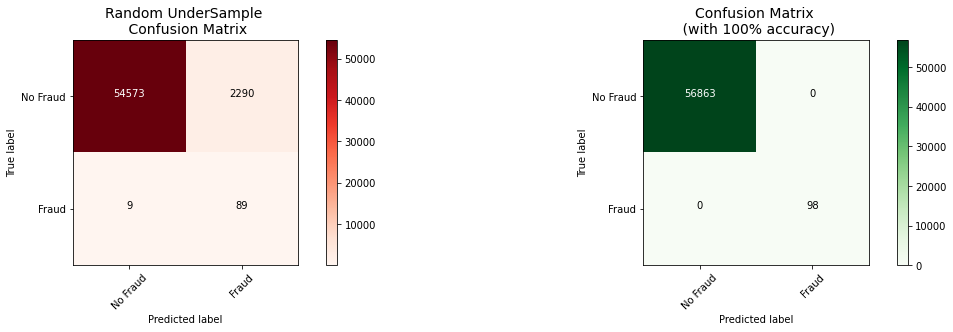

In [61]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Keras || OverSampling (SMOTE):


In [62]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [63]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 4s - loss: 0.0578 - accuracy: 0.9792 - val_loss: 0.0200 - val_accuracy: 0.9958
Epoch 2/20
1214/1214 - 3s - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.0090 - val_accuracy: 0.9990
Epoch 3/20
1214/1214 - 3s - loss: 0.0077 - accuracy: 0.9984 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 4/20
1214/1214 - 3s - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0073 - val_accuracy: 0.9992
Epoch 5/20
1214/1214 - 3s - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0050 - val_accuracy: 0.9997
Epoch 6/20
1214/1214 - 3s - loss: 0.0035 - accuracy: 0.9994 - val_loss: 7.3400e-04 - val_accuracy: 1.0000
Epoch 7/20
1214/1214 - 3s - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0020 - val_accuracy: 0.9997
Epoch 8/20
1214/1214 - 3s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9999
Epoch 9/20
1214/1214 - 3s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 10/20
1214/1214 - 3s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 3.010

In [65]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [66]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56839    24]
 [   29    69]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


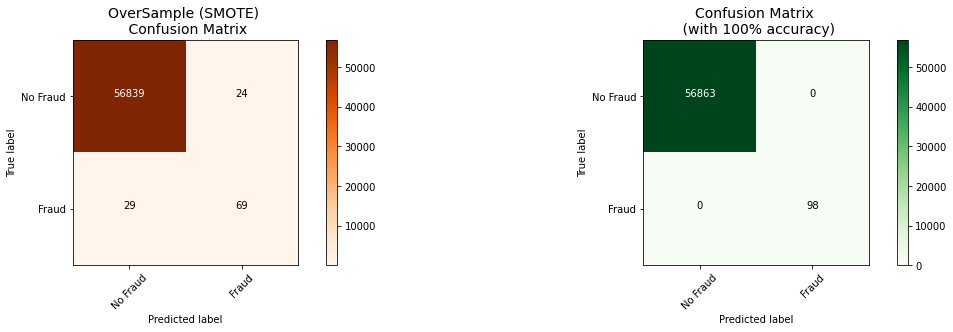

In [67]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Conclusion
Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more no fraud than fraud transactions). Nevertheless, I still have to state that sometimes the neural network on the oversampled dataset predicts less correct fraud transactions than our model using the undersample dataset. However, remember that the removal of outliers was implemented only on the random undersample dataset and not on the oversampled one. Also, in our undersample data our model is unable to detect for a large number of cases non fraud transactions correctly and instead, misclassifies those non fraud transactions as fraud cases. Imagine that people that were making regular purchases got their card blocked due to the reason that our model classified that transaction as a fraud transaction, this will be a huge disadvantage for the financial institution. The number of customer complaints and customer disatisfaction will increase.  The next step of this analysis will be to do an outlier removal on our oversample dataset and see if our accuracy in the test set improves. <br><br>

- 불균형한 데이터셋에 SMOTE를 구현한 덕분에 레이블의 불균형(부정 행위 트랜잭션 이상의 부정 행위 없음)을 해결할 수 있었다.
- 그럼에도 불구하고 때때로 오버샘플링된 데이터셋의 신경 네트워크가 언더샘플링된 데이터셋을 사용하는 모델에 비해 덜 정확한 부정 행위 트랜잭션을 예측한다는 점을 언급해야 합니다.
- 그러나 특이치 제거는 오버샘플이 아닌 랜덤 언더샘플 데이터 집합에만 구현되었습니다.
- 또한 샘플 부족 데이터의 경우 모델이 부정 행위 이외의 많은 트랜잭션을 올바르게 감지하지 못하고 부정 행위 이외의 트랜잭션을 부정 행위 사례로 잘못 분류합니다.
- 당사 모델이 해당 거래를 부정거래로 분류한 이유로 정기 구매를 하던 사람들이 카드를 차단당했다고 가정해 보면 금융기관에 큰 불이익이 될 것입니다.
- 고객 불만과 고객 불만이 증가할 것입니다.
- 이 분석의 다음 단계는 오버샘플 데이터 세트에서 특이치를 제거하고 테스트 세트의 정확도가 향상되는지 확인하는 것입니다.